# MLP - Multilayer Perceptron vs. Convolutional Neural Network

Iremos utilizar dois modelos com o mesmo dataset para verificar os diferentes desempenhos do mesmo. 

## Preparo dos Dados:

Vamos adicionar um pouco de translação as imagens do dataset:

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random

In [2]:
def transform_imagens(X, borda):
    novoX = torch.zeros(1, 28 + 2*borda, 28 + 2*borda)
    inicio_h = random.randint(0, 2 * borda)
    inicio_v = random.randint(0, 2 * borda)
    novoX[0, inicio_h:(inicio_h + 28), inicio_v:(inicio_v + 28)] = X[0].view(28, 28)
    return novoX

def carrega_imagens_mnist(file_path, borda=28, transformar=True):
    data = pd.read_csv(file_path)

    rotulos = data['label'].values
    imagens = data.drop(columns=['label']).values

    if transformar:
        imagens_transformadas = []

        for img in imagens:
            imagem_tensor = torch.tensor(img, dtype=torch.float).view(1, 28, 28)
            imagem_transformada = transform_imagens(imagem_tensor, borda)
            imagem_transformada = imagem_transformada / 255.0
            imagens_transformadas.append(imagem_transformada)


        imagens_tensor = torch.stack(imagens_transformadas)
    else:
        imagens_tensor = torch.tensor(imagens, dtype=torch.float).view(-1, 1, 28, 28) / 255.0

    imagens_tensor = imagens_tensor
    rotulos_tensor = torch.tensor(rotulos, dtype=torch.long)

    return imagens_tensor, rotulos_tensor

In [3]:
path_treino = 'datasets/fashion-mnist_train.csv'
path_teste = 'datasets/fashion-mnist_test.csv'

dados_treino, rotulos_treino = carrega_imagens_mnist(path_treino)
dados_teste, rotulos_teste = carrega_imagens_mnist(path_teste)

In [4]:
dados_treino_og, _ = carrega_imagens_mnist(path_treino, transformar=False)
dados_teste_og, _ = carrega_imagens_mnist(path_teste, transformar=False)

In [5]:
def plot_imagens(imagens, num_colunas=5, scale=0.5):
    num_imagens = len(imagens)
    num_linhas = (num_imagens + num_colunas - 1) // num_colunas

    fig, axes = plt.subplots(num_linhas, num_colunas, figsize=(num_colunas * scale, num_linhas * scale))
    axes = axes.flatten()

    for i, (img, ax) in enumerate(zip(imagens, axes)):
        ax.imshow(img.numpy().squeeze(), cmap='inferno')
        ax.axis('off')  # Remove os eixos para uma visualização mais limpa

    for ax in axes[num_imagens:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

torch.Size([60000, 1, 84, 84])
torch.Size([1, 84, 84])


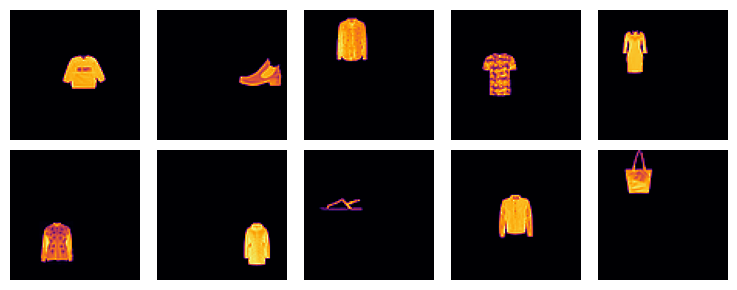

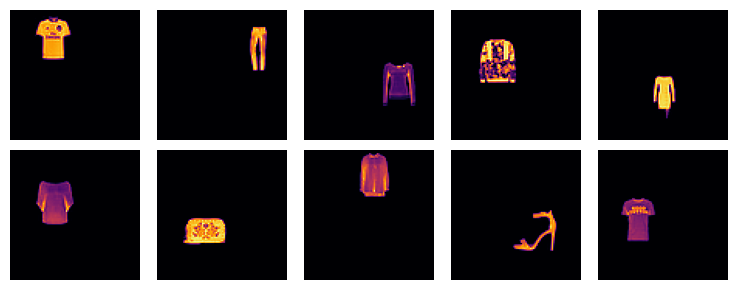

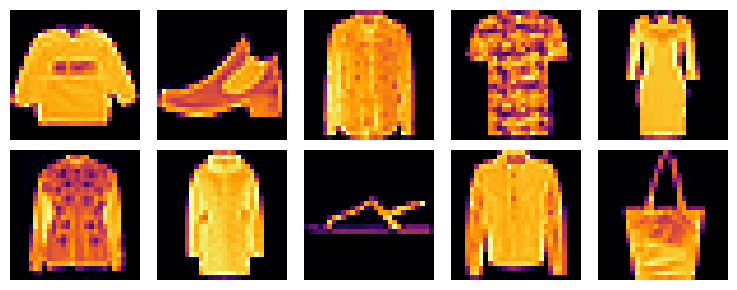

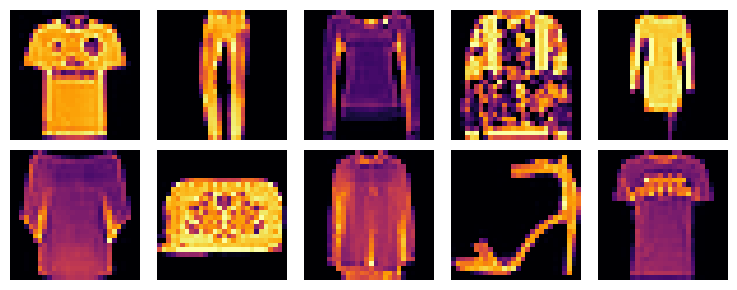

In [6]:
print(dados_treino.shape)
print(dados_treino[0].shape)
plot_imagens(dados_treino[:10].cpu(), num_colunas=5, scale=1.5)
plot_imagens(dados_teste[:10].cpu(), num_colunas=5, scale=1.5)
plot_imagens(dados_treino_og[:10].cpu(), num_colunas=5, scale=1.5)
plot_imagens(dados_teste_og[:10].cpu(), num_colunas=5, scale=1.5)

## MLP - Definições do Modelo:

### Definição das Camadas:

Estamos abaixo definindo as 3 camadas:

Camada 1:
$$
W_1 \in \mathbb{R}^{7056 \times 128} \\ 
b_1 \in \mathbb{R}^{128} 
$$
Camada 2:
$$
W_2 \in \mathbb{R}^{128 \times 64} \\
 b_2 \in \mathbb{R}^{64} \\
$$
Camada 3:
$$
W_3 \in \mathbb{R}^{64 \times 10} \\
b_3 \in \mathbb{R}^{10}
$$

In [7]:
import torch.nn as nn

tamanho_entrada = 84 * 84
camada_oculta1 = 128
camada_oculta2 = 64
camada_saida = 10

camada1 = nn.Linear(tamanho_entrada, camada_oculta1)
camada2 = nn.Linear(camada_oculta1, camada_oculta2)
camada3 = nn.Linear(camada_oculta2, camada_saida)

Para acessar os vetores de peso, podemos:

In [8]:
print(camada1.weight.shape)
print(camada1.bias.shape)
print(camada2.weight.shape)
print(camada2.bias.shape)
print(camada3.weight.shape)
print(camada3.bias.shape)

torch.Size([128, 7056])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [22]:
def plot_side_by_side(lista_perdas1, acuracias1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Cria dois gráficos lado a lado

    # Plot para lista_perdas1
    ax1.plot(lista_perdas1, label='Transformada')
    ax1.set_title('Perdas')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda')
    ax1.legend()

    # Plot para acuracias1
    ax2.plot(acuracias1, label='Transformada', color='orange')
    ax2.set_title('Acurácias')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Acurácia')
    ax2.legend()

    plt.tight_layout()  # Ajusta o layout para não sobrepor elementos
    plt.show()

### Classe do Modelo:

In [21]:
class MLP(nn.Module):
    def __init__(self, tamanho_entrada, camada_oculta1, camada_oculta2, camada_saida, func_ativacao):
        super(MLP, self).__init__()
        self.camada1 = nn.Linear(tamanho_entrada, camada_oculta1)
        self.camada2 = nn.Linear(camada_oculta1, camada_oculta2)
        self.camada3 = nn.Linear(camada_oculta2, camada_saida)

        if func_ativacao == 'sigmoid':
            self.func_ativacao = nn.Sigmoid()
        else:
            self.func_ativacao = nn.ReLU()

    def forward(self, X):
        X = X.view(X.size(0), -1)
        X = self.func_ativacao(self.camada1(X))
        X = self.func_ativacao(self.camada2(X))
        X = self.camada3(X)
        return X

## Treinamento:

In [23]:
def acuracia(saidas, rotulos):
    _, predicao = torch.max(saidas, 1)
    return (predicao == rotulos).sum().item() / len(predicao)

def teste(modelo, dados_teste, rotulos_teste):
    modelo.eval()
    saidas = modelo(dados_teste)
    acc = acuracia(saidas, rotulos_teste)
    print(f' >> Acurácia: {acc}')


def treino(modelo, otimizador, perda, dados, num_epocas = 10):
    lista_perdas = []
    acuracias = []

    for epoca in range(num_epocas):
        modelo.train()
        otimizador.zero_grad()

        saidas = modelo(dados)
        acc = acuracia(saidas, rotulos_treino)
        acuracias.append(acc)
        erro = perda(saidas, rotulos_treino)

        erro.backward()
        otimizador.step()
        lista_perdas.append(erro.item())
        # print(f'Epoca {epoca+1}/{num_epocas}, Perda: {erro.item()}, Acc: {acc}')

    return lista_perdas, acuracias


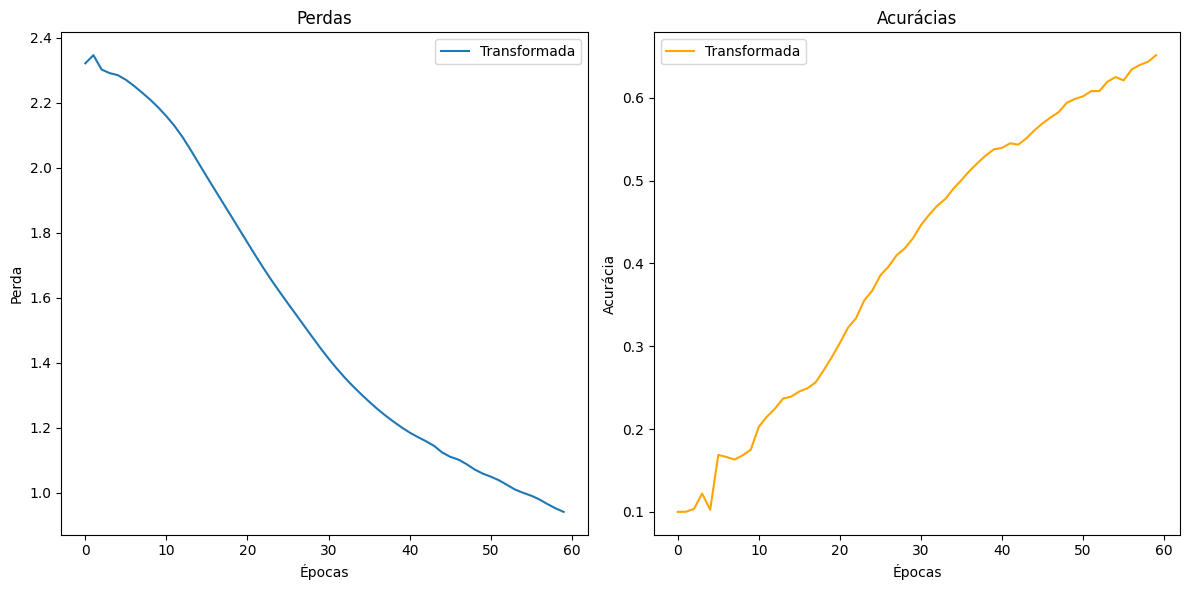

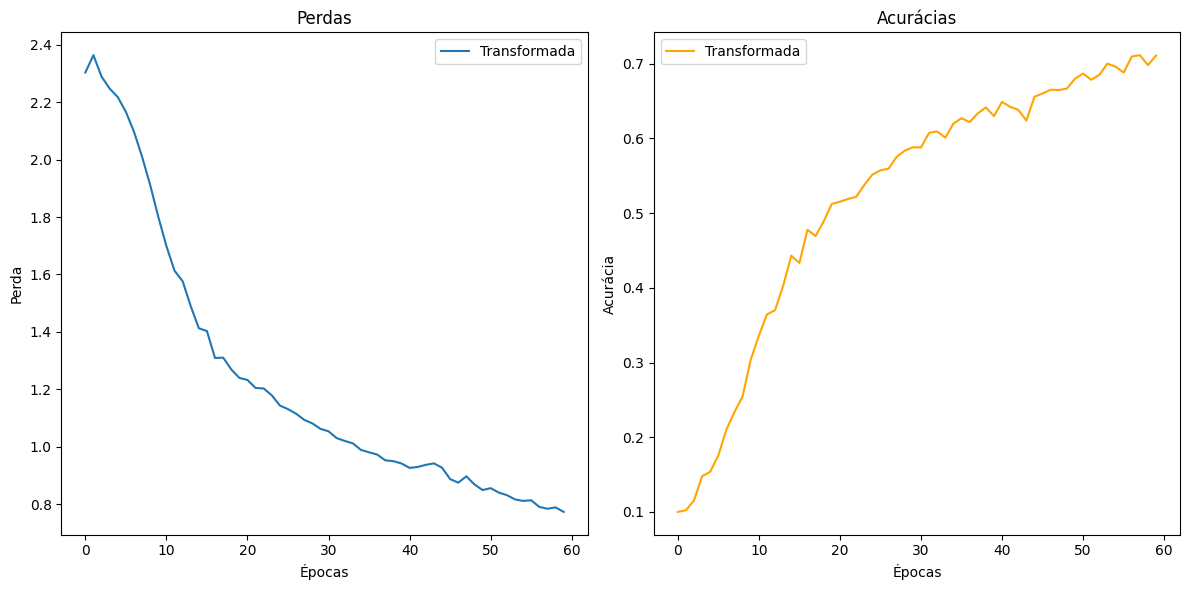

Modelo 1: 
 >> Acurácia: 0.5796
Modelo 2: 
 >> Acurácia: 0.658


In [25]:
# Parâmetros da entrada e camadas ocultas:
tamanho_entrada = 84 * 84
camada_oculta1 = 128
camada_oculta2 = 64
camada_saida = 10

# Modelos:
modelo1 = MLP(tamanho_entrada, camada_oculta1, camada_oculta2, camada_saida, 'sigmoid')
modelo2 = MLP(tamanho_entrada, camada_oculta1, camada_oculta2, camada_saida, 'relu')

# Otimizadores e função de perda:
perda = nn.CrossEntropyLoss()
otimizador1 = torch.optim.Adam(modelo1.parameters(), lr=0.01)
otimizador2 = torch.optim.Adam(modelo2.parameters(), lr=0.01)

# Treinamento e teste:
lista_perdas1, acuracias1 = treino(modelo1, otimizador1, perda, dados_treino, num_epocas=60)
lista_perdas2, acuracias2 = treino(modelo2, otimizador2, perda, dados_treino, num_epocas=60)

plot_side_by_side(lista_perdas1, acuracias1)
plot_side_by_side(lista_perdas2, acuracias2)

print("Modelo 1: ")
teste(modelo1, dados_teste, rotulos_teste)
print("Modelo 2: ")
teste(modelo2, dados_teste, rotulos_teste)

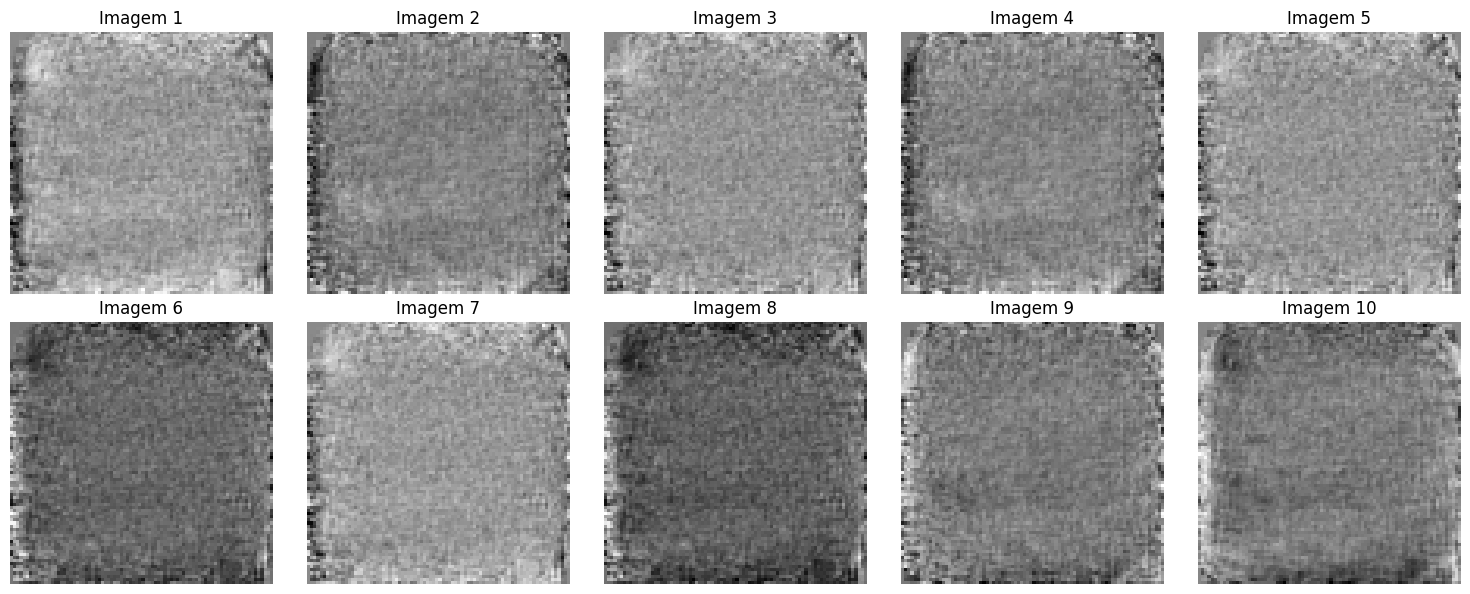

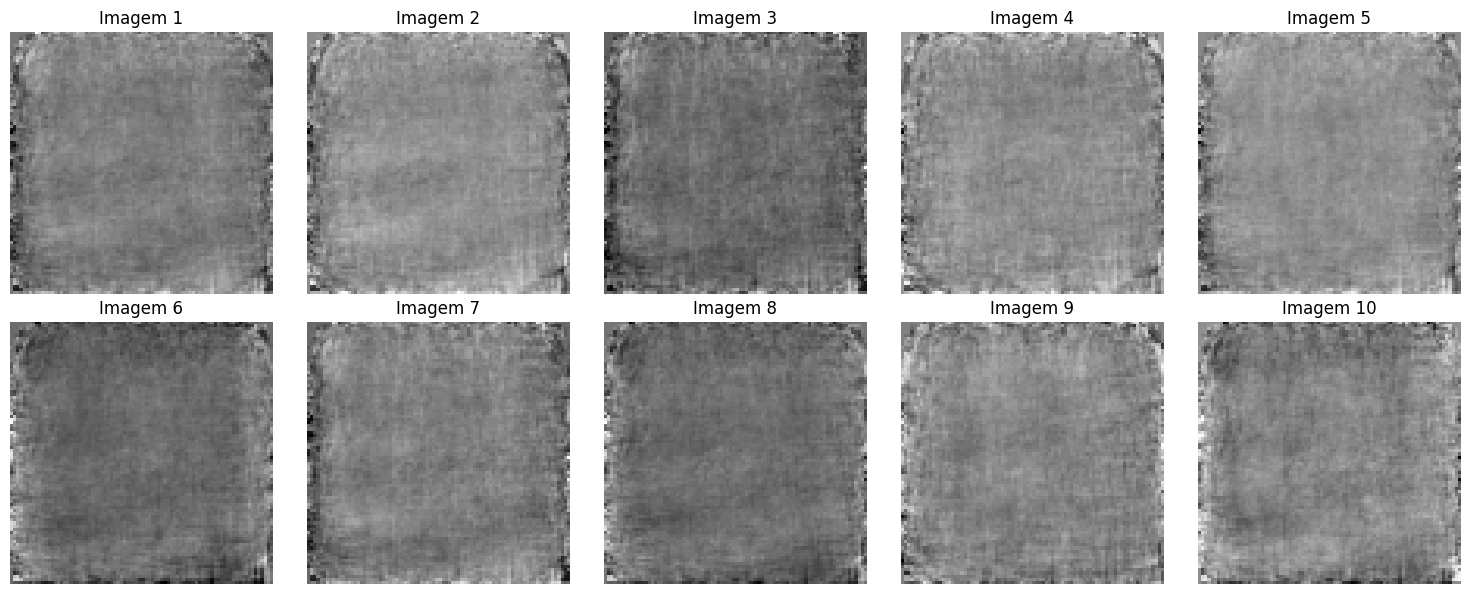

In [44]:
def plot_vetores_de_peso(modelo, dimensao = 84):
    aux = modelo.camada3.weight @ modelo.camada2.weight
    aux = aux @ modelo.camada1.weight
    aux = aux.view(10, dimensao, dimensao)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  
    for i in range(10):
        ax = axes[i // 5, i % 5]
        ax.imshow(aux[i].detach().numpy(), cmap='gray')
        ax.set_title(f'Imagem {i + 1}')
        ax.axis('off')  
    
    plt.tight_layout()
    plt.show()


plot_vetores_de_peso(modelo1)
plot_vetores_de_peso(modelo2)




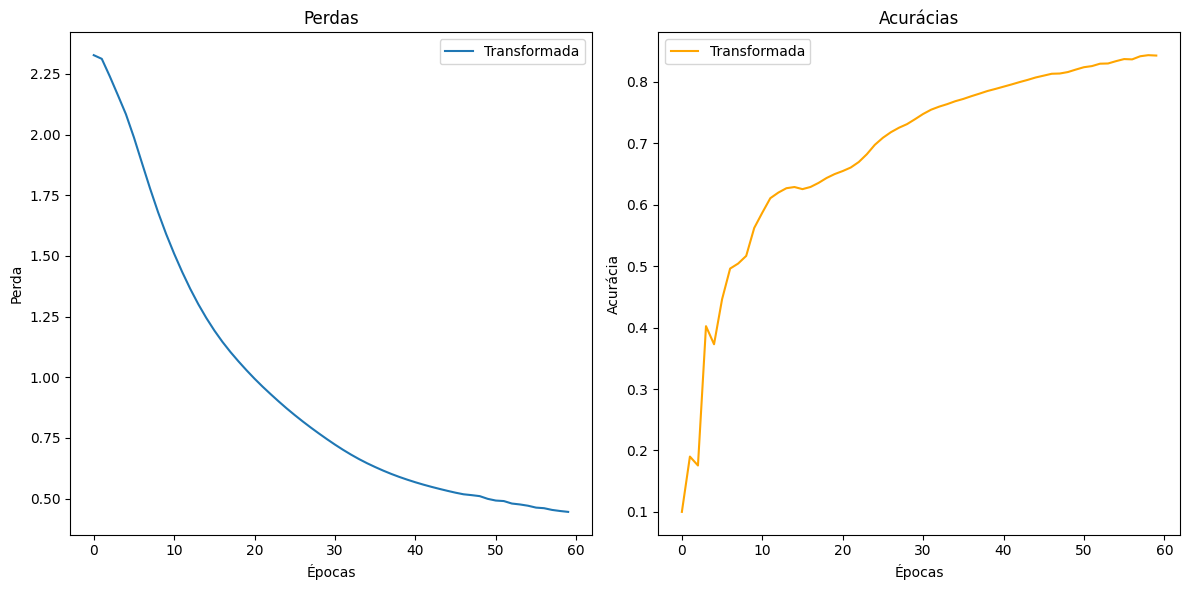

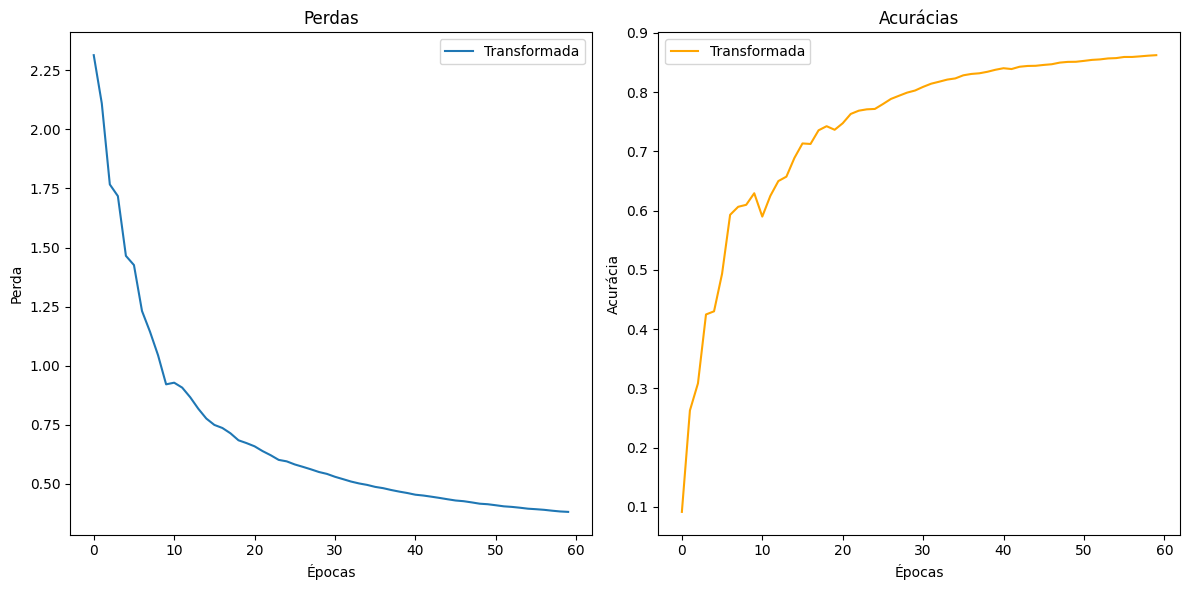

Modelo 3: 
 >> Acurácia: 0.846
Modelo 4: 
 >> Acurácia: 0.8582


In [39]:

# Parâmetros da entrada e camadas ocultas:
tamanho_entrada = 28 * 28
camada_oculta1 = 128
camada_oculta2 = 64
camada_saida = 10

# Modelos:
modelo3 = MLP(tamanho_entrada, camada_oculta1, camada_oculta2, camada_saida, 'sigmoid')
modelo4 = MLP(tamanho_entrada, camada_oculta1, camada_oculta2, camada_saida, 'relu')

# Otimizadores e função de perda:
perda = nn.CrossEntropyLoss()
otimizador3 = torch.optim.Adam(modelo3.parameters(), lr=0.01)
otimizador4 = torch.optim.Adam(modelo4.parameters(), lr=0.01)

# Treinamento e teste:
lista_perdas3, acuracias3 = treino(modelo3, otimizador3, perda, dados_treino_og, num_epocas=60)
lista_perdas4, acuracias4 = treino(modelo4, otimizador4, perda, dados_treino_og, num_epocas=60)

plot_side_by_side(lista_perdas3, acuracias3)
plot_side_by_side(lista_perdas4, acuracias4)

print("Modelo 3: ")
teste(modelo3, dados_teste_og, rotulos_teste)
print("Modelo 4: ")
teste(modelo4, dados_teste_og, rotulos_teste)

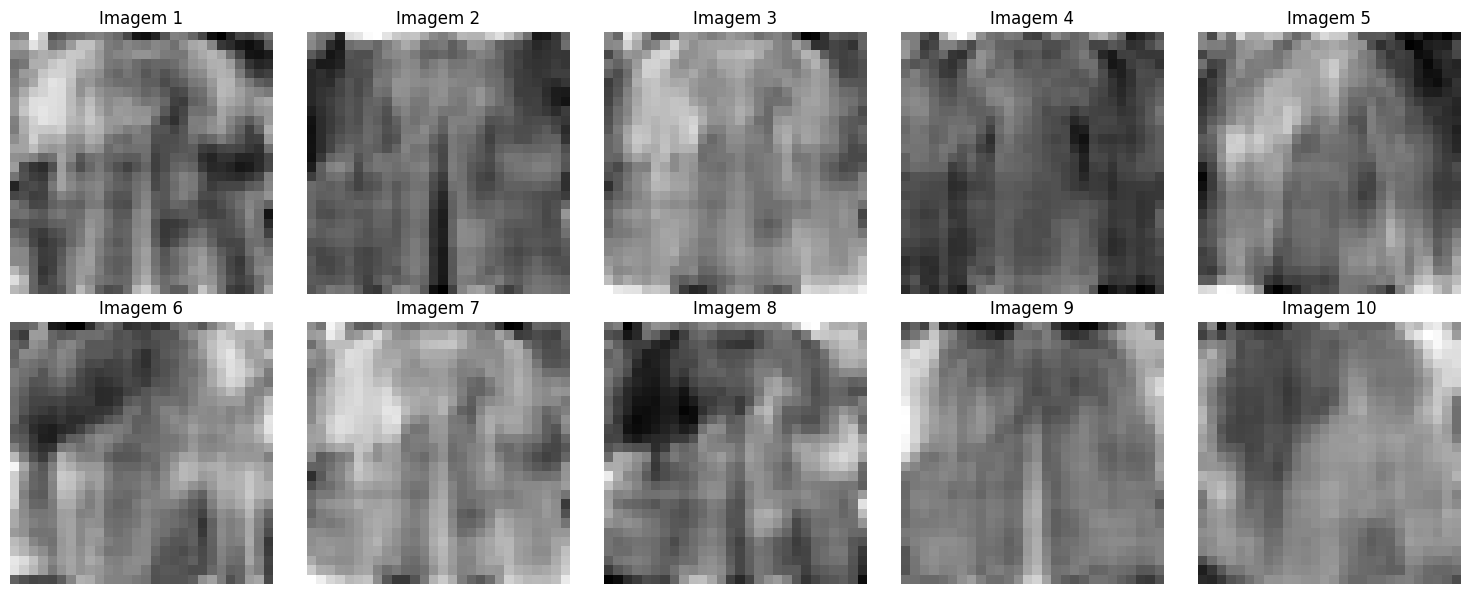

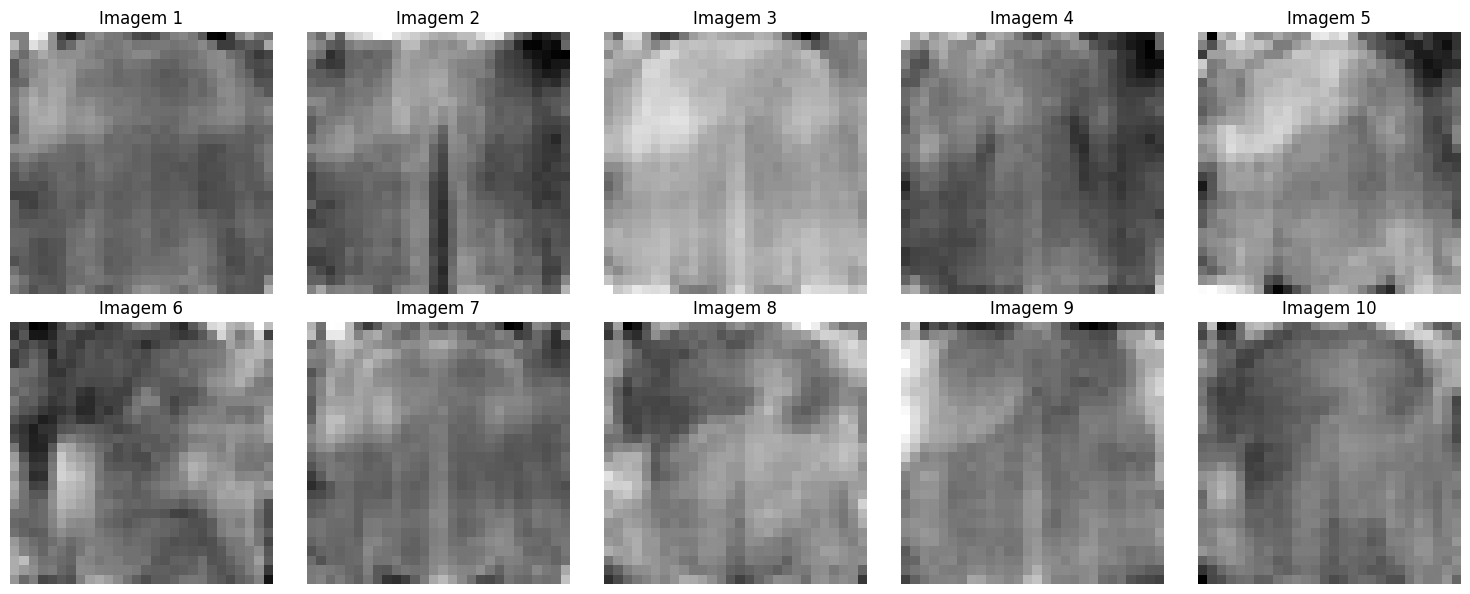

In [45]:
plot_vetores_de_peso(modelo3, dimensao=28)
plot_vetores_de_peso(modelo4, dimensao=28)